In [452]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, auc, roc_auc_score, roc_curve


In [453]:
# ! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

In [454]:

df = pd.read_csv('AER_credit_card_data.csv')
df.tail().T

,1314,1315,1316,1317,1318
card,yes,no,yes,yes,yes
reports,0,5,0,0,0
age,33.58333,23.91667,40.58333,32.83333,48.25
income,4.566,3.192,4.6,3.7,3.7
share,0.002146,0.000376,0.026513,0.008999,0.111619
expenditure,7.333333,0.0,101.2983,26.99667,344.1575
owner,yes,no,yes,no,yes
selfemp,no,no,no,yes,no
dependents,0,3,2,0,2
months,94,12,1,60,2


In [455]:
# target variable by mapping 
# df.card = df.card.map(dict(yes=1, no=0))

In [456]:
# # df.card = df.card.map(dict(yes=1, no=0))
# y = df.card.values
# del df['card']
# df.shape, y.shape

# train_ratio = 0.60
# test_ratio = 0.20
# validation_ratio = 0.20

# df_X_train, df_X_test, y_train, y_test = train_test_split(df, y, test_size=test_ratio, random_state=1)
# df_X_train, df_X_valid, y_train, y_valid = train_test_split(df_X_train, y_train, test_size=validation_ratio/(train_ratio+test_ratio), random_state=1)

# # df_X_train.reset_index(inplace=True, drop=True)
# # df_X_valid.reset_index(inplace=True, drop=True)
# # df_X_test.reset_index(inplace=True, drop=True)

# print(df_X_train.shape)
# print(df_X_test.shape)
# print(df_X_valid.shape)

In [457]:
train_ratio = 0.60
test_ratio = 0.20
validation_ratio = 0.20

# df_X_train, df_X_test, y_train, y_test = train_test_split(df, y, test_size=test_ratio, random_state=1)
# df_X_train, df_X_valid, y_train, y_valid = train_test_split(df_X_train, y_train, test_size=validation_ratio/(train_ratio+test_ratio), random_state=1)

df_full_train, df_test = train_test_split(df, test_size=test_ratio, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=validation_ratio/(train_ratio+test_ratio), random_state=1)


df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

print(df_train.shape, df_val.shape, df_test.shape)

(791, 11) (264, 11) (264, 11)


In [458]:
assert df_train.shape[0] + df_val.shape[0] + df_test.shape[0] == df.shape[0]

In [459]:

# df.card = df.card.map(dict(yes=1, no=0))

# df_full_train, df_test = train_test_split(df, test_size=.2, random_state=1)
# df_train, df_val = train_test_split(df_full_train, test_size=.2, random_state=1)


# df_train.reset_index(inplace=True, drop=True)
# df_val.reset_index(inplace=True, drop=True)
# df_test.reset_index(inplace=True, drop=True)

# y_train = df_train.card.values
# y_val = df_val.card.values
# y_test = df_test.card.values

# del df_train['card']
# del df_val['card']
# del df_test['card']

# print(df_train.shape, df_val.shape, df_test.shape)

Question 1
- ROC AUC could also be used to evaluate feature importance of numerical variables.



In [460]:
numerical = df_train.select_dtypes(include=np.number).columns.tolist()
numerical

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [461]:
for feat in numerical:
    auc = roc_auc_score(y_train, df_train[feat])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[feat])
    print('%9s, %.3f' % (feat, auc)) 

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


Training the model
- Apply one-hot-encoding using DictVectorizer and train the logistic regression 
- `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`


In [462]:
df_train.dtypes

reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [463]:
# Encode 
train_dict = df_train[['owner', 'selfemp'] + numerical].to_dict(orient='records')
val_dict = df_val[['owner', 'selfemp'] + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

In [464]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)

model.fit(X_train, y_train)

# _y_val_pred = model.predict(X_val)
y_valid_pred = model.predict_proba(X_val)[:, 1]

Question 2
- What's the `AUC` of this model on the validation dataset? (round to 3 digits)

In [465]:
round(roc_auc_score(y_val, y_valid_pred), 3)

0.995

Question 3  
Now let's compute precision and recall for our model:
- Evaluate the model on the validation dataset on all thresholds from *0.0 to 1.0 with step 0.01*
- For each threshold, *compute precision and recall*
- Plot them

In [466]:
scores = []
thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    actual_positive = (y_val == 'yes')
    actual_negative = (y_val == 'no')
    
    predict_positive = (y_valid_pred >= threshold)
    predict_negative = (y_valid_pred < threshold)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((threshold, tp, fp, fn, tn))
  
columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)    

print (df_scores.head())
print (df_scores.tail())

   thresholds   tp  fp  fn  tn
0        0.00  211  53   0   0
1        0.01  211  34   0  19
2        0.02  211  31   0  22
3        0.03  211  24   0  29
4        0.04  211  22   0  31
     thresholds   tp  fp  fn  tn
96         0.96  204   0   7  53
97         0.97  203   0   8  53
98         0.98  203   0   8  53
99         0.99  202   0   9  53
100        1.00  179   0  32  53


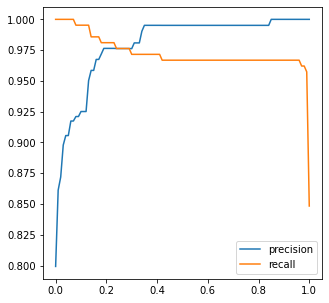

In [467]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.figure(figsize=(5, 5))

plt.plot(df_scores.thresholds, df_scores.p, label='precision')
plt.plot(df_scores.thresholds, df_scores.r, label='recall')

plt.legend()
plt.show()

Question 4
- Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both
- $F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$

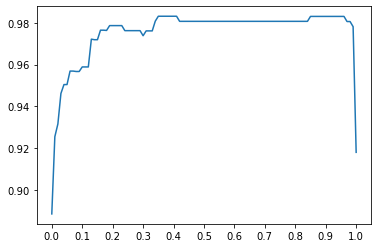

In [468]:

df_scores['f1'] = 2 * (df_scores.p * df_scores.r ) / (df_scores.p + df_scores.r)
plt.plot(df_scores.thresholds, df_scores.f1)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

Question 5
- Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

In [407]:
train_ratio = 0.60
test_ratio = 0.20
validation_ratio = 0.20

df_X_train, df_X_test = train_test_split(df, test_size=test_ratio, random_state=1)
df_X_train, df_X_valid = train_test_split(df_X_train, test_size=validation_ratio/(train_ratio+test_ratio), random_state=1)

# df_X_train.reset_index(inplace=True, drop=True)
# df_X_valid.reset_index(inplace=True, drop=True)
# df_X_test.reset_index(inplace=True, drop=True)

print(df_X_train.shape)
print(df_X_test.shape)
print(df_X_valid.shape)

(791, 11)
(264, 11)
(264, 11)


In [470]:
df_full_train

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
710,no,1,36.83333,3.0000,0.000400,0.000000,yes,no,1,12,1,16
1258,yes,0,35.58333,3.5606,0.109084,323.587500,no,no,0,12,1,0
435,yes,0,25.66667,2.0000,0.004900,7.416667,no,no,0,26,1,13
987,no,0,25.58333,1.7500,0.000686,0.000000,no,no,0,108,0,0
1286,yes,1,48.66667,6.0000,0.177017,885.085800,yes,no,3,114,1,19
...,...,...,...,...,...,...,...,...,...,...,...,...
715,yes,0,38.33333,5.0000,0.057248,238.365000,yes,no,3,9,1,0
905,yes,1,32.50000,10.0000,0.037040,308.250000,yes,no,3,35,1,4
1096,yes,0,19.16667,1.9000,0.282962,448.023300,no,no,0,192,0,1
235,yes,0,30.83333,3.0000,0.062629,156.572500,yes,no,2,72,1,8


In [516]:
scores = []
dv = DictVectorizer(sparse=False)
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    # Encode
    train_dict = df_train[['owner', 'selfemp'] + numerical].to_dict(orient='records')
    val_dict = df_val[['owner', 'selfemp'] + numerical].to_dict(orient='records')
    
    dv.fit(train_dict)
    X_train = dv.transform(train_dict)
    X_val = dv.transform(val_dict)

    # train model
    model.fit(X_train, y_train)

    # Evaluate on validation data
    y_val_pred = model.predict_proba(X_val)[:, 1]

    # Compute metrics
    auc = roc_auc_score(y_val, y_val_pred)
    scores.append(auc)

    # print(f' Fold{kfold.n_splits} Mean AUC: { np.mean(scores) }, Deviation: { np.std(scores) } ')
    print(f'fold = {1:>1} '
    f' mean AUC: {np.mean(scores):<10.5f}'
    f' std deviation: {np.std(scores):<10.3f} ')

with Fold = 1  mean AUC: 0.99419    std deviation: 0.000      
with Fold = 1  mean AUC: 0.99415    std deviation: 0.000      
with Fold = 1  mean AUC: 0.99421    std deviation: 0.000      
with Fold = 1  mean AUC: 0.99556    std deviation: 0.002      
with Fold = 1  mean AUC: 0.99645    std deviation: 0.003      


In [471]:
# scores = []

# kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# for train_idx, val_idx in kfold.split(df_full_train):
#     df_train = df_full_train.iloc[train_idx]
#     df_val = df_full_train.iloc[val_idx]

#     y_train = df_train.card.values
#     y_val = df_val.card.values

#     dv, model = train(df_train, y_train, C=1.0)
#     y_pred = predict(df_val, dv, model)

#     auc = roc_auc_score(y_val, y_pred)
#     scores.append(auc)

# print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

(844, 12)
(844, 12)
(844, 12)
(844, 12)
(844, 12)


Question 6
- Now let's use 5-Fold cross-validation to find the best parameter C
- Iterate over the following C values: `[0.01, 0.1, 1, 10]`

In [513]:

dv = DictVectorizer(sparse=False)

for C in [0.01, 0.1, 1, 10]:
  scores = []
  kfold = KFold(n_splits=5, shuffle=True, random_state=1)

  for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    # Encode
    train_dict = df_train[['owner', 'selfemp'] + numerical].to_dict(orient='records')
    val_dict = df_val[['owner', 'selfemp'] + numerical].to_dict(orient='records')
    
    dv.fit(train_dict)
    X_train = dv.transform(train_dict)
    X_val = dv.transform(val_dict)

    # train model
    model = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
    model.fit(X_train, y_train)

    # Evaluate on validation data
    y_val_pred = model.predict_proba(X_val)[:, 1]

    # Compute metrics
    auc = roc_auc_score(y_val, y_val_pred)
    scores.append(auc)

  print(f'with C = {C:>5} '
        f' mean AUC: {np.mean(scores):<10.5f}'
        f' std deviation: {np.std(scores):<10.5f} ')

with C =  0.01  mean AUC: 0.99188    std deviation: 0.00560    
with C =   0.1  mean AUC: 0.99506    std deviation: 0.00395    
with C =     1  mean AUC: 0.99645    std deviation: 0.00274    
with C =    10  mean AUC: 0.99639    std deviation: 0.00282    
